In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("MyApp1")
    .master("spark://spark-master:7077")
    # Use a hadoop-aws matching your Hadoop (common choice below)
    .config(
        "spark.jars.packages",
        ",".join([
            "org.apache.hadoop:hadoop-aws:3.4.1",           # match your Hadoop
            "org.apache.spark:spark-avro_2.12:3.4.1"        # match your Spark
        ])
    )
    # MinIO S3A setup
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000")
    .config("spark.hadoop.fs.s3a.path.style.access", "true")  # REQUIRED for MinIO
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin")           # set access key
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin123456")     # set secret key
    # Optional timeouts (ms), numeric only
    .config("spark.hadoop.fs.s3a.connection.timeout", "30000")
    .config("spark.hadoop.fs.s3a.connection.establish.timeout", "30000")
    .config("spark.hadoop.fs.s3a.attempts.maximum", "10")
    .getOrCreate()
)

In [2]:
hv = spark.sparkContext._gateway.jvm.org.apache.hadoop.util.VersionInfo.getVersion()
print("Hadoop version:", hv)

Hadoop version: 3.4.1


In [3]:
jconf = spark._jsc.hadoopConfiguration()
print("endpoint =", jconf.get("fs.s3a.endpoint"))
print("access.key =", jconf.get("fs.s3a.access.key"))
print("secret.key =", jconf.get("fs.s3a.secret.key"))
print("path.style =", jconf.get("fs.s3a.path.style.access"))
print("ssl.enabled =", jconf.get("fs.s3a.connection.ssl.enabled"))

endpoint = http://minio:9000
access.key = minioadmin
secret.key = minioadmin123456
path.style = true
ssl.enabled = false


In [4]:
sc = spark.sparkContext
jconf = sc._jsc.hadoopConfiguration()

# sanity check: these must be set
print("endpoint =", jconf.get("fs.s3a.endpoint"))
print("access.key =", jconf.get("fs.s3a.access.key"))
print("path.style =", jconf.get("fs.s3a.path.style.access"))

# Get the FS for the s3a URI explicitly
uri = sc._jvm.java.net.URI("s3a://datalake/")
fs = sc._jvm.org.apache.hadoop.fs.FileSystem.get(uri, jconf)
Path = sc._jvm.org.apache.hadoop.fs.Path

print("Exists:",
      fs.exists(Path("s3a://datalake/bronze/sales/orders/")))

endpoint = http://minio:9000
access.key = minioadmin
path.style = true
Exists: True


In [5]:
# read csv from minio bucket "data" file "sample.csv"
print(spark.version)
df = spark.read.csv("s3a://datalake/bronze/sales/orders/orders.csv", header=True, inferSchema=True)
# show dataframe
df.show()

src_path_csv = f"s3a://datalake/bronze/sales/orders/orders.csv"

input_format = "csv"  # lahko "csv" | "json" | "parquet" | "avro"
input_path = src_path_csv  # npr. tvoj obstoječi vir v bronze

read_options = {}
if input_format == "csv":
    read_options = {"header": "true", "inferSchema": "true"}
elif input_format == "json":
    read_options = {"multiLine": "true"}  # po potrebi
else:
    read_options = {}

print("Branje iz:", input_path, "format:", input_format, "options:", read_options)

4.0.1
+--------+-----------+------+
|order_id|customer_id|amount|
+--------+-----------+------+
|       1|       1001| 29.99|
|       2|       1002|  15.5|
+--------+-----------+------+

Branje iz: s3a://datalake/bronze/sales/orders/orders.csv format: csv options: {'header': 'true', 'inferSchema': 'true'}


In [6]:
df = spark.read.format(input_format).options(**read_options).load(input_path)
print("Število vrstic:", df.count())
df.show(truncate=False)
df.printSchema()

Število vrstic: 2
+--------+-----------+------+
|order_id|customer_id|amount|
+--------+-----------+------+
|1       |1001       |29.99 |
|2       |1002       |15.5  |
+--------+-----------+------+

root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- amount: double (nullable = true)



In [7]:
bronze_csv = "s3a://datalake/bronze/sales/orders/orders.csv"  # tvoja pot

df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(bronze_csv)
)

print("Vrstice:", df.count())
df.show(10, truncate=False)
df.printSchema()

Vrstice: 2
+--------+-----------+------+
|order_id|customer_id|amount|
+--------+-----------+------+
|1       |1001       |29.99 |
|2       |1002       |15.5  |
+--------+-----------+------+

root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- amount: double (nullable = true)



In [8]:
base_out = "s3a://datalake/bronze/formats/orders"  # ciljni prefix v bronze
paths = {
    "json":    f"{base_out}/json",
    "avro":    f"{base_out}/avro",
    "parquet": f"{base_out}/parquet",
}

# JSON
(df.coalesce(1)
   .write.mode("overwrite")
   .json(paths["json"]))

# Avro
(df.coalesce(1)
   .write.mode("overwrite")
   .format("avro")
   .save(paths["avro"]))

# Parquet
(df.coalesce(1)
   .write.mode("overwrite")
   .parquet(paths["parquet"]))

paths

{'json': 's3a://datalake/bronze/formats/orders/json',
 'avro': 's3a://datalake/bronze/formats/orders/avro',
 'parquet': 's3a://datalake/bronze/formats/orders/parquet'}

In [9]:
from pyspark.sql import functions as F

def show_stats(dfi):
    # numerični povzetki
    num_cols = [f.name for f in dfi.schema.fields if "DecimalType" in str(f.dataType) or str(f.dataType) in {"IntegerType","LongType","FloatType","DoubleType","ShortType"}]
    if num_cols:
        dfi.select(*[F.col(c).cast("double").alias(c) for c in num_cols])\
           .summary("count","mean","stddev","min","max").show(truncate=False)
    # kategorike: št. različnih vrednosti
    cat_cols = [f.name for f in dfi.schema.fields if f.name not in num_cols]
    if cat_cols:
        dfi.agg(*[F.countDistinct(F.col(c)).alias(f"{c}_distinct") for c in cat_cols])\
           .show(truncate=False)

for fmt, path in paths.items():
    print(f"\n=== {fmt.upper()} ===")
    reader = spark.read.format("avro" if fmt=="avro" else fmt)
    if fmt == "json":
        dfi = reader.load(path)
    else:
        dfi = reader.load(path)
    print("Vrstice:", dfi.count())
    dfi.show(10, truncate=False)
    dfi.printSchema()
    show_stats(dfi)


=== JSON ===
Vrstice: 2
+------+-----------+--------+
|amount|customer_id|order_id|
+------+-----------+--------+
|29.99 |1001       |1       |
|15.5  |1002       |2       |
+------+-----------+--------+

root
 |-- amount: double (nullable = true)
 |-- customer_id: long (nullable = true)
 |-- order_id: long (nullable = true)

+---------------+--------------------+-----------------+
|amount_distinct|customer_id_distinct|order_id_distinct|
+---------------+--------------------+-----------------+
|2              |2                   |2                |
+---------------+--------------------+-----------------+


=== AVRO ===
Vrstice: 2
+--------+-----------+------+
|order_id|customer_id|amount|
+--------+-----------+------+
|1       |1001       |29.99 |
|2       |1002       |15.5  |
+--------+-----------+------+

root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- amount: double (nullable = true)

+-----------------+--------------------+----------

In [12]:
sc = spark.sparkContext
jconf = sc._jsc.hadoopConfiguration()
jvm = sc._jvm
URI = jvm.java.net.URI
Path = jvm.org.apache.hadoop.fs.Path
FS = jvm.org.apache.hadoop.fs.FileSystem

# Bind FS to the bucket's s3a URI
s3_fs = FS.get(URI("s3a://datalake/"), jconf)

def dir_size_bytes(uri: str) -> int:
    p = Path(uri)
    total = 0
    if not s3_fs.exists(p):
        return 0
    for st in s3_fs.listStatus(p):
        name = st.getPath().getName()
        if st.isFile():
            if name.startswith("_") or name.startswith("."):
                continue
            total += st.getLen()
        else:
            total += dir_size_bytes(st.getPath().toString())
    return int(total)

# now use it
sizes = {fmt: dir_size_bytes(path) for fmt, path in paths.items()}
sizes

{'json': 97, 'avro': 319, 'parquet': 1037}

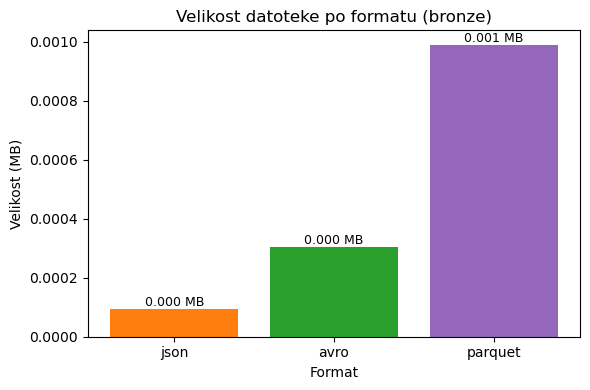

In [13]:
import matplotlib.pyplot as plt

formats = ["json","avro","parquet"]
vals_mb = [sizes[f]/(1024*1024) for f in formats]

plt.figure(figsize=(6,4))
bars = plt.bar(formats, vals_mb, color=["#ff7f0e","#2ca02c","#9467bd"])
plt.ylabel("Velikost (MB)")
plt.xlabel("Format")
plt.title("Velikost datoteke po formatu (bronze)")
for b, v in zip(bars, vals_mb):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.3f} MB", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

In [14]:
src_csv = "s3a://datalake/bronze/sales/orders/orders.csv"

df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(src_csv)
)
print("rows:", df.count())
df.printSchema()

rows: 2
root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- amount: double (nullable = true)



In [16]:
import time

sc = spark.sparkContext
jvm = sc._jvm
URI = jvm.java.net.URI
Path = jvm.org.apache.hadoop.fs.Path
FS = jvm.org.apache.hadoop.fs.FileSystem
s3_fs = FS.get(URI("s3a://datalake/"), spark._jsc.hadoopConfiguration())

def dir_size_bytes(uri: str) -> int:
    p = Path(uri)
    if not s3_fs.exists(p):
        return 0
    total = 0
    for st in s3_fs.listStatus(p):
        name = st.getPath().getName()
        if st.isFile():
            if name.startswith("_") or name.startswith("."):
                continue
            total += st.getLen()
        else:
            total += dir_size_bytes(st.getPath().toString())
    return int(total)

def write_avro_with_compression(df, out_path: str, codec: str, deflate_level: int | None = None):
    writer = (
        df.coalesce(1)  # demonstracija: en part; odstrani v praksi
        .write.mode("overwrite")
        .format("avro")
        .option("compression", codec)
    )
    if codec.lower() == "deflate" and deflate_level is not None:
        # 0–9 (višji = večja kompresija, počasnejše pisanje)
        writer = writer.option("deflate-level", str(deflate_level))
    t0 = time.perf_counter()
    writer.save(out_path)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    size_b = dir_size_bytes(out_path)
    return elapsed, size_b

In [17]:
base_out = "s3a://datalake/bronze/avro_compression/orders"  # prilagodi
paths = {
    "snappy":  f"{base_out}/snappy",
    "deflate": f"{base_out}/deflate_lvl6",  # primer: level 6
}

results = {}

# Snappy
t_snappy, sz_snappy = write_avro_with_compression(df, paths["snappy"], codec="snappy")
results["snappy"] = {"time_s": t_snappy, "size_b": sz_snappy}

# Deflate (npr. level 6 je dobra sredina)
t_defl, sz_defl = write_avro_with_compression(df, paths["deflate"], codec="deflate", deflate_level=6)
results["deflate"] = {"time_s": t_defl, "size_b": sz_defl}

results

{'snappy': {'time_s': 1.0718534830011777, 'size_b': 319},
 'deflate': {'time_s': 0.9985461819996999, 'size_b': 312}}

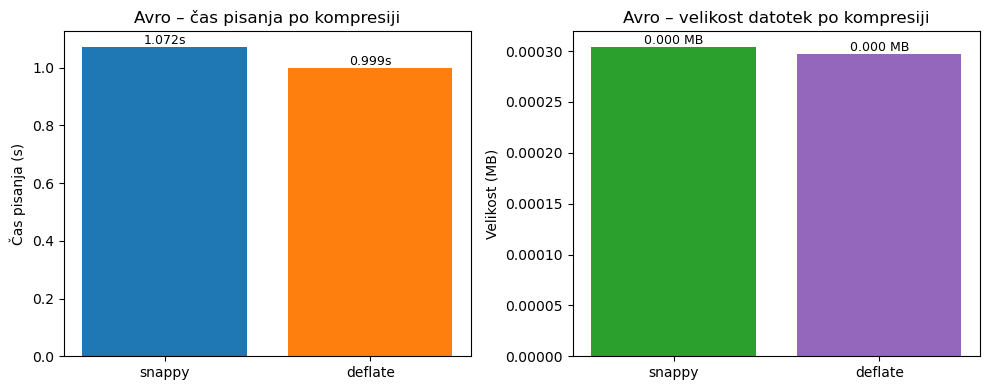

In [18]:
import matplotlib.pyplot as plt

techs = ["snappy", "deflate"]
times = [results[t]["time_s"] for t in techs]
sizes_mb = [results[t]["size_b"] / (1024 * 1024) for t in techs]

plt.figure(figsize=(10,4))

# (a) Čas pisanja
plt.subplot(1,2,1)
bars1 = plt.bar(techs, times, color=["#1f77b4","#ff7f0e"])
plt.ylabel("Čas pisanja (s)")
plt.title("Avro – čas pisanja po kompresiji")
for b, v in zip(bars1, times):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.3f}s", ha="center", va="bottom", fontsize=9)

# (b) Velikost
plt.subplot(1,2,2)
bars2 = plt.bar(techs, sizes_mb, color=["#2ca02c","#9467bd"])
plt.ylabel("Velikost (MB)")
plt.title("Avro – velikost datotek po kompresiji")
for b, v in zip(bars2, sizes_mb):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.3f} MB", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

In [19]:
src_csv = "s3a://datalake/bronze/sales/orders/orders.csv"  # prilagodi

bronze_df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(src_csv)
)

print("Bronze rows:", bronze_df.count())
bronze_df.show(10, truncate=False)
bronze_df.printSchema()

Bronze rows: 2
+--------+-----------+------+
|order_id|customer_id|amount|
+--------+-----------+------+
|1       |1001       |29.99 |
|2       |1002       |15.5  |
+--------+-----------+------+

root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- amount: double (nullable = true)



In [20]:
from pyspark.sql import functions as F

df = bronze_df

# 2.1 normaliziraj imena stolpcev -> snake_case
def to_snake(s): 
    return "".join([c.lower() if c.isalnum() else "_" for c in s]).replace("__","_").strip("_")
df = df.toDF(*[to_snake(c) for c in df.columns])

# Predpostavimo nekaj tipičnih stolpcev
# order_id (string/int), customer_id (string/int), qty (int), price (double), tax_rate (double [% ali 0-1]), ts (timestamp/date)
# Prilagodi mape glede na svoje dejanske stolpce:
casts = {
    "order_id": "string",
    "customer_id": "string",
    "qty": "int",
    "price": "double",
    "tax_rate": "double",
    "ts": "timestamp",
}
for c, t in casts.items():
    if c in df.columns:
        df = df.withColumn(c, F.col(c).cast(t))

# 2.2 očisti negativne/nesmiselne vrednosti
if "qty" in df.columns:
    df = df.filter(F.col("qty") >= 0)
if "price" in df.columns:
    df = df.filter(F.col("price") >= 0)

# 2.3 dodaj izračunane stolpce
# total = qty * price
if set(["qty","price"]).issubset(df.columns):
    df = df.withColumn("total", (F.col("qty") * F.col("price")).cast("double"))

# total_with_tax (če je tax_rate podan v % pretvori na 0-1)
if "tax_rate" in df.columns:
    # heuristika: če je tipično >1, jemlji kot %, sicer kot faktor
    df = df.withColumn(
        "tax_factor",
        F.when(F.col("tax_rate") > 1, F.col("tax_rate") / F.lit(100.0)).otherwise(F.col("tax_rate"))
    )
    if "total" in df.columns:
        df = df.withColumn("total_with_tax", (F.col("total") * (1 + F.col("tax_factor"))).cast("double"))

# 2.4 datum in particije (year, month)
if "ts" in df.columns:
    df = df.withColumn("order_date", F.to_date(F.col("ts")))
    df = df.withColumn("year", F.year("order_date")).withColumn("month", F.month("order_date"))

# 2.5 deduplikacija po order_id, ohrani najnovejši ts če obstaja
if "order_id" in df.columns:
    w = F.window if False else None  # placeholder, uporabimo dropDuplicates za enostavnost
    subset = ["order_id"]
    df = df.sort(F.col("ts").desc() if "ts" in df.columns else F.lit(1)).dropDuplicates(subset)

silver_df = df.cache()
print("Silver rows:", silver_df.count())
silver_df.show(10, truncate=False)
silver_df.printSchema()

Silver rows: 2
+--------+-----------+------+
|order_id|customer_id|amount|
+--------+-----------+------+
|1       |1001       |29.99 |
|2       |1002       |15.5  |
+--------+-----------+------+

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- amount: double (nullable = true)



In [21]:
# numerični povzetki
num_cols = [f.name for f in silver_df.schema.fields if str(f.dataType) in {"IntegerType","LongType","FloatType","DoubleType","ShortType"} or "DecimalType" in str(f.dataType)]
if num_cols:
    silver_df.select(*[F.col(c).cast("double").alias(c) for c in num_cols])\
        .summary("count","mean","stddev","min","max").show(truncate=False)

# kategorike: distincti
cat_cols = [c for c in silver_df.columns if c not in num_cols]
if cat_cols:
    silver_df.agg(*[F.countDistinct(c).alias(f"{c}_distinct") for c in cat_cols]).show(truncate=False)

+-----------------+--------------------+---------------+
|order_id_distinct|customer_id_distinct|amount_distinct|
+-----------------+--------------------+---------------+
|2                |2                   |2              |
+-----------------+--------------------+---------------+



In [22]:
silver_base = "s3a://datalake/silver/sales/orders_parquet"  # prilagodi

writer = silver_df.coalesce(1).write.mode("overwrite").format("parquet")
if set(["year","month"]).issubset(silver_df.columns):
    writer = writer.partitionBy("year","month")

writer.save(silver_base)
print("Zapisano v:", silver_base)

Zapisano v: s3a://datalake/silver/sales/orders_parquet


In [24]:
silver_src = "s3a://datalake/silver/sales/orders_parquet"  # prilagodi na svoj silver vir

silver_df = spark.read.parquet(silver_src)
print("rows:", silver_df.count())
silver_df.printSchema()
silver_df.show(10, truncate=False)

rows: 2
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- amount: double (nullable = true)

+--------+-----------+------+
|order_id|customer_id|amount|
+--------+-----------+------+
|1       |1001       |29.99 |
|2       |1002       |15.5  |
+--------+-----------+------+



In [25]:
import time

sc = spark.sparkContext
jvm = sc._jvm
URI = jvm.java.net.URI
Path = jvm.org.apache.hadoop.fs.Path
FS = jvm.org.apache.hadoop.fs.FileSystem
s3_fs = FS.get(URI("s3a://datalake/"), spark._jsc.hadoopConfiguration())

def dir_size_bytes(uri: str) -> int:
    p = Path(uri)
    if not s3_fs.exists(p):
        return 0
    total = 0
    for st in s3_fs.listStatus(p):
        name = st.getPath().getName()
        if st.isFile():
            if name.startswith("_") or name.startswith("."):
                continue
            total += st.getLen()
        else:
            total += dir_size_bytes(st.getPath().toString())
    return int(total)

def write_parquet_with_compression(df, out_path: str, codec: str):
    writer = (
        df.coalesce(1)  # demonstracijsko en part; v praksi odstrani
        .write.mode("overwrite")
        .option("compression", codec)  # "snappy" ali "gzip"
        .parquet(out_path)
    )
    t0 = time.perf_counter()
    # zapis se izvrši zgoraj (action je lazy pri write.save, zato uporabimo .parquet)
    t1 = time.perf_counter()
    # za realno meritev forsiraj akcijo: preberi nazaj count
    read_back = spark.read.parquet(out_path)
    cnt = read_back.count()
    t2 = time.perf_counter()
    elapsed_write = (t1 - t0)  # zapis kot tak
    # v nekaterih okoljih je meritev bolj realna, če šteješ do t2 - t0; tu poročamo oba
    size_b = dir_size_bytes(out_path)
    return {"write_s": elapsed_write, "write_plus_read_s": (t2 - t0), "rows": cnt, "size_b": size_b}

In [26]:
base_out = "s3a://datalake/silver/compression_parquet/orders"  # prilagodi
paths = {
    "snappy": f"{base_out}/snappy",
    "gzip":   f"{base_out}/gzip",
}

results = {}
results["snappy"] = write_parquet_with_compression(silver_df, paths["snappy"], "snappy")
results["gzip"]   = write_parquet_with_compression(silver_df, paths["gzip"],   "gzip")

results

{'snappy': {'write_s': 6.999980541877449e-07,
  'write_plus_read_s': 0.29346574999726727,
  'rows': 2,
  'size_b': 1031},
 'gzip': {'write_s': 6.999980541877449e-07,
  'write_plus_read_s': 0.2890734190004878,
  'rows': 2,
  'size_b': 1070}}

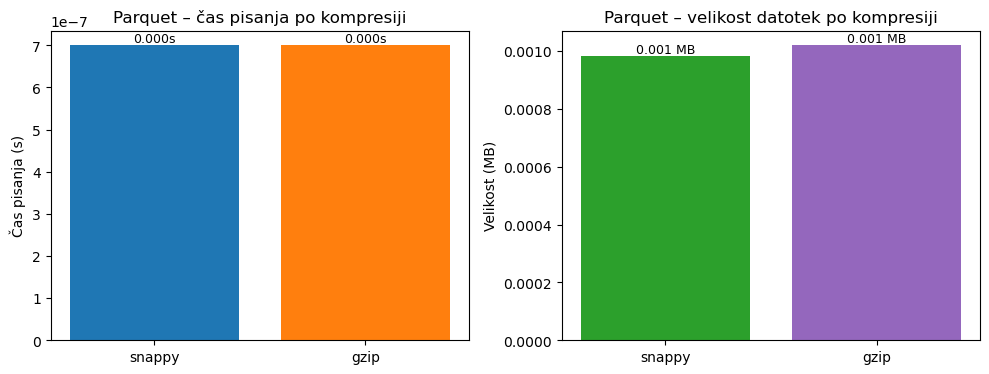

In [27]:
import matplotlib.pyplot as plt

techs = ["snappy", "gzip"]
times = [results[t]["write_s"] for t in techs]
times_full = [results[t]["write_plus_read_s"] for t in techs]  # opcijsko
sizes_mb = [results[t]["size_b"] / (1024 * 1024) for t in techs]

plt.figure(figsize=(10,4))

# (a) Čas pisanja (samo write)
plt.subplot(1,2,1)
bars1 = plt.bar(techs, times, color=["#1f77b4","#ff7f0e"])
plt.ylabel("Čas pisanja (s)")
plt.title("Parquet – čas pisanja po kompresiji")
for b, v in zip(bars1, times):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.3f}s", ha="center", va="bottom", fontsize=9)

# (b) Velikost
plt.subplot(1,2,2)
bars2 = plt.bar(techs, sizes_mb, color=["#2ca02c","#9467bd"])
plt.ylabel("Velikost (MB)")
plt.title("Parquet – velikost datotek po kompresiji")
for b, v in zip(bars2, sizes_mb):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{v:.3f} MB", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

In [28]:
silver_src = "s3a://datalake/silver/sales/orders_parquet"  # prilagodi

silver_df = spark.read.parquet(silver_src)
print("Silver rows:", silver_df.count())
silver_df.printSchema()
silver_df.show(10, truncate=False)

Silver rows: 2
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- amount: double (nullable = true)

+--------+-----------+------+
|order_id|customer_id|amount|
+--------+-----------+------+
|1       |1001       |29.99 |
|2       |1002       |15.5  |
+--------+-----------+------+



In [29]:
from pyspark.sql import functions as F

df = silver_df

# Če nimaš total, ga izračunaj iz qty*price (prilagodi stolpce)
if all(c in df.columns for c in ["qty", "price"]) and "total" not in df.columns:
    df = df.withColumn("total", (F.col("qty") * F.col("price")).cast("double"))

# Če nimaš order_date, ga tvori iz ts
if "order_date" not in df.columns and "ts" in df.columns:
    df = df.withColumn("order_date", F.to_date("ts"))

# year, month za particioniranje/agregacijo
if "order_date" in df.columns:
    df = df.withColumn("year", F.year("order_date")).withColumn("month", F.month("order_date"))

df = df.cache()
print("Prepared rows:", df.count())

Prepared rows: 2


In [30]:
group_keys = [c for c in ["year", "month", "customer_id"] if c in df.columns]
if not group_keys:
    # fallback: agregiraj samo po year/month ali globalno
    group_keys = [c for c in ["year", "month"] if c in df.columns]

agg_exprs = []
if "order_id" in df.columns:
    agg_exprs.append(F.countDistinct("order_id").alias("orders_cnt"))
if "qty" in df.columns:
    agg_exprs.append(F.sum(F.col("qty").cast("double")).alias("qty_sum"))
    agg_exprs.append(F.avg(F.col("qty").cast("double")).alias("qty_avg"))
if "total" in df.columns:
    agg_exprs.append(F.sum("total").alias("revenue_sum"))
    agg_exprs.append(F.avg("total").alias("revenue_avg"))
    agg_exprs.append(F.max("total").alias("revenue_max"))
    agg_exprs.append(F.min("total").alias("revenue_min"))

agg_df = df.groupBy(*group_keys).agg(*agg_exprs)

# dodatni KPI-ji
if set(["revenue_sum","orders_cnt"]).issubset(agg_df.columns):
    agg_df = agg_df.withColumn("revenue_per_order", F.col("revenue_sum")/F.col("orders_cnt"))

agg_df = agg_df.orderBy(*group_keys)
agg_df.show(20, truncate=False)
agg_df.printSchema()

+-----------+----------+
|customer_id|orders_cnt|
+-----------+----------+
|1001       |1         |
|1002       |1         |
+-----------+----------+

root
 |-- customer_id: string (nullable = true)
 |-- orders_cnt: long (nullable = false)



In [31]:
num_cols = [f.name for f in agg_df.schema.fields if any(t in str(f.dataType) for t in ["IntegerType","LongType","FloatType","DoubleType","DecimalType"])]
if num_cols:
    agg_df.select(*[F.col(c).cast("double").alias(c) for c in num_cols])\
          .summary("count","mean","stddev","min","max").show(truncate=False)

+-------+----------+
|summary|orders_cnt|
+-------+----------+
|count  |2         |
|mean   |1.0       |
|stddev |0.0       |
|min    |1.0       |
|max    |1.0       |
+-------+----------+



In [32]:
gold_out = "s3a://datalake/gold/sales/orders_agg_parquet"  # prilagodi

writer = agg_df.coalesce(1).write.mode("overwrite").format("parquet")
# smiselno particioniranje, če obstaja
part_cols = [c for c in ["year","month"] if c in agg_df.columns]
if part_cols:
    writer = writer.partitionBy(*part_cols)

writer.save(gold_out)
print("Zapisano v:", gold_out)

Zapisano v: s3a://datalake/gold/sales/orders_agg_parquet


In [33]:
check = spark.read.parquet(gold_out)
print("Gold rows:", check.count())
check.show(20, truncate=False)
check.printSchema()

Gold rows: 2
+-----------+----------+
|customer_id|orders_cnt|
+-----------+----------+
|1001       |1         |
|1002       |1         |
+-----------+----------+

root
 |-- customer_id: string (nullable = true)
 |-- orders_cnt: long (nullable = true)



In [ ]:
spark.stop()